In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set(style="whitegrid")

## Forward Simulation

Parameters:

In [3]:
alpha = 0.9
beta = 0.2
lambda_p = [1,5]
gamma = 0.1

Big gamma matrix:

In [4]:
big_gamma = np.array([
    [1- gamma, 0, gamma], 
    [0, 1-gamma, gamma], 
    [beta/2, beta/2, 1- beta]
    ])

Simulation function

In [5]:
def sim(n,T):
    C = [None]*T
    C[0] = 2
    C_trans = {(1,0,0): 0, (0,1,0): 1, (0,0,1): 2} 

    for i in range(1,T):
        draw = np.random.multinomial(1, big_gamma[C[i-1], :], 1)
        C[i] = C_trans[tuple(draw[0])]

    Z = np.empty([n, T])

    probs = {0: 1-alpha, 1: alpha, 2: 0.5}
    
    Zs = [np.random.binomial(1, p = probs[c], size = n) for c in C]
    Z_flat = np.array(Zs).flat

    Xs = np.reshape([np.random.poisson(1+4*z) for z in Z_flat], newshape=(T, n))

    return [C, Zs, Xs]


## Visualizing

In [6]:
C, Z, X = sim(10,100)

In [7]:
color = {0:'red', 1:'green', 2: 'blue'}
C_color = [color[c] for c in C]
C_color

['blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'blue',
 'green',
 'green',
 'green',
 'green',
 'green',
 'blue',
 'green',
 'green',
 'blue',
 'blue',
 'red',
 'red',
 'red']

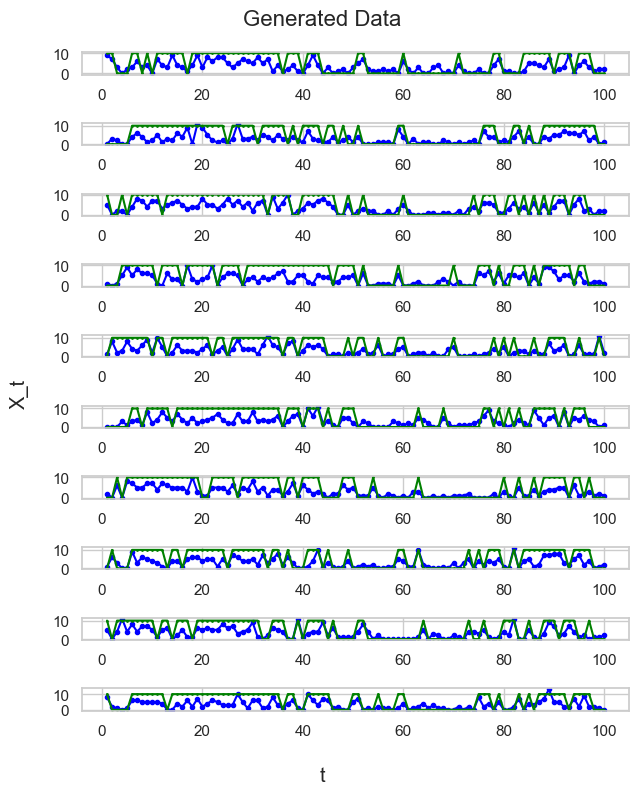

In [8]:
fig, axs = plt.subplots(10, 1, figsize= (6.5, 8))
x_plot = list(range(1,100+1))

for i in range(10):
    y_plot = X[:, i] 
    axs[i].plot(x_plot, y_plot, marker='o', markersize=3, color='blue')
    y_plot_z = [Z[0][i]*10]
    for j in range(1,100):
        y_plot_z.append(Z[j][i]*10)
    axs[i].plot(x_plot, y_plot_z, marker='o', markersize=1, color = 'green')
    #axs[i].text(1.05, 0.5, f'{i + 1}', fontsize=12, rotation=270)

fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

plt.tight_layout()
plt.show()


In [9]:
X_avg = [None]*100

for i in range(100):
    X_avg[i] = np.mean(X[i,:])

Text(0.5, 1.0, 'Average')

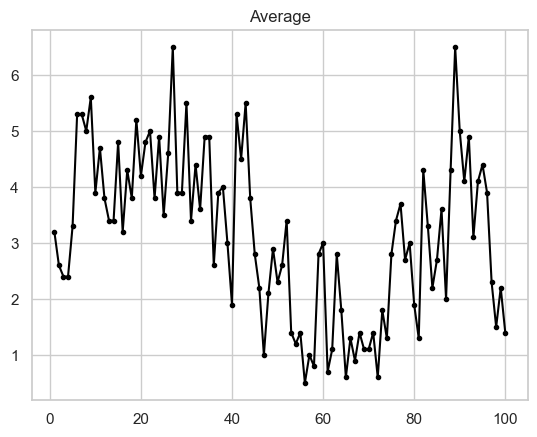

In [10]:
plt.plot(x_plot, X_avg, marker='o', markersize=3, color='black')
plt.title('Average')

## Multinomial logistic regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

Simulate lots of data

In [12]:
n1 = 1000
n2 = 10
T = 100

np.random.seed(42)

C, Z, X = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1,T,n2))

for i in range(n1):
    C[i], Z[i], X[i] = sim(n2,T)


In [13]:
X_reg = X.reshape((1000, n2*T))
lr = LogisticRegression(max_iter=5000)
lr.fit(X_reg, C[:,49])

LogisticRegression(max_iter=5000)

Prediction accuracy

In [14]:
np.random.seed(80)
n1 = 1000

C_test, Z_test, X_test = np.empty(shape=(n1,T)), np.empty(shape=(n1,T,n2)), np.empty(shape=(n1, T, n2))

for i in range(n1):
    C_test[i], Z_test[i], X_test[i] = sim(10,100)

X_reg_test = X_test.reshape((1000, 100*10))

np.mean(lr.predict(X_reg_test) == C_test[:,49])


0.668

In [15]:
lr.coef_

array([[ 0.03707576,  0.07556136,  0.02679373, ...,  0.01847613,
        -0.02778083,  0.03911787],
       [-0.06965838, -0.17429022,  0.01776721, ..., -0.01074624,
        -0.03011102, -0.04705927],
       [ 0.03258263,  0.09872886, -0.04456094, ..., -0.00772989,
         0.05789184,  0.0079414 ]])

In [16]:
print(np.mean(lr.coef_[0]), np.mean(lr.coef_[1]), np.mean(lr.coef_[2]))

-0.000813642936020122 -9.472616592041926e-05 0.0009083691019386659


Predict from only certain X's

In [17]:
new_x_reg = X[:,48:51,:]
new_x_reg = new_x_reg.reshape((1000, 10*3))

In [18]:
lr2 = LogisticRegression(max_iter=5000)
lr2.fit(new_x_reg, C[:,49])

LogisticRegression(max_iter=5000)

Accuracy

In [19]:
X_reg_test = X_test[:,48:51,:]
X_reg_test = X_reg_test.reshape((1000, 10*3))

np.mean(lr2.predict(X_reg_test) == C_test[:,49])

0.882

# Inference

In [20]:
import math
from functools import reduce
from itertools import product

In [21]:
n = 3
T = 5
p_zc = np.array([[alpha, 1-alpha],[1-alpha,alpha], [0.5,0.5]]) #(C_i,Z_ij)

p_zc

array([[0.9, 0.1],
       [0.1, 0.9],
       [0.5, 0.5]])

Clique potentials

In [36]:
psi_l_1 = np.array([big_gamma[0]*0, big_gamma[1]*0, big_gamma[2]*1]) #(C_1,C_2)
psi_l_i = big_gamma #(C_i,C_i+1) # i = 1,..,T-1
psi_m_i = np.zeros(shape = [3,n+1]) #(C_i, #Z_ij = 1) i = 1,..,T-1, j=1,..,n 
for c_val in range(3):
    psi_m_i[c_val,:] = [(p_zc[c_val,0]**(n-sum_z_ij))*(p_zc[c_val,1]**(sum_z_ij)) for sum_z_ij in range(n+1)]

In [38]:
def psi_n_i(xs):
    def func(zs):
        k = sum(zs)
        lambdas = reduce(lambda x, y: x * y, [lambda_p[z]**x for z,x in zip(zs, xs)])
        factorials = reduce(lambda x,y: x*y, [math.factorial(x) for x in xs])
        exponentials = np.exp( - ((len(zs) - k) * lambda_p[0] + k * lambda_p[1]))
        return exponentials * lambdas / factorials
    return func


Data

In [39]:
C, Z, X = sim(n,T)

Messages: Upwards pass

In [40]:
# Sending messag from N_i clique (consists of X's and Z's) to M_i (consists of Z's and C_i) clique 
delta_ni_mi_list = [None]*T
for i in range(T):
    delta_ni_mi_list[i] = psi_n_i(X[i,:]) # function of Zs

In [41]:
# Sending messag from M_i clique (consists of Z's and C_i) to L_i clique (C_i and C_{i+1}) 
delta_mi_li_list = np.empty(shape = (T,3)) #(t,C_t) t=1,...,T
for t in range(T):
    for c_val in range(3):
        delta_mi_li_list[t, c_val] = sum([psi_m_i[c_val,sum(zs)] * delta_ni_mi_list[t](zs) for zs in list(product([0, 1], repeat=n))])

In [42]:
# Sending messag from L_i clique (consists of C_i and C_i+1) to L_i+1 clique (C_i+1 and C_{i+2}) 
delta_li_i1_list = np.empty(shape = (T-1,3)) #(t, C_t+1) t=1,...,T-1

for t in range(T-1):
    for c_i_ in range(3):
        if t == 0:
            delta_li_i1_list[t,c_i_] = sum([psi_l_1[c_i,c_i_] * delta_mi_li_list[0,c_i] for c_i in [0,1,2]])
        delta_li_i1_list[t, c_i_] = sum([psi_l_i[c_i,c_i_] * delta_mi_li_list[t,c_i] for c_i in [0,1,2]])

#Downward pass
Clique belief of clique L_{T-1}

In [134]:
beta_l_T_minus_1 = np.empty(shape = (3,3)) 
beta_l_T_minus_1[0,:] = psi_l_i[0,:]*delta_mi_li_list[T-1,:]*delta_li_i1_list[T-2,0]*delta_mi_li_list[T-2,0]
beta_l_T_minus_1[1,:] = psi_l_i[1,:]*delta_mi_li_list[T-1,:]*delta_li_i1_list[T-2,1]*delta_mi_li_list[T-2,1]
beta_l_T_minus_1[2,:] = psi_l_i[2,:]*delta_mi_li_list[T-1,:]*delta_li_i1_list[T-2,2]*delta_mi_li_list[T-2,2]
#Normalizing
beta_l_T_minus_1 /= sum(sum(beta_l_T_minus_1))
beta_l_T_minus_1

array([[3.46183122e-04, 0.00000000e+00, 1.77186831e-03],
       [0.00000000e+00, 6.97602461e-01, 1.54231058e-02],
       [4.73952423e-04, 1.09722695e-01, 1.74659734e-01]])

In [144]:
beliefs_l_t = np.empty(shape = (T-1,3,3)) # (t,C_t,C_{t+1})
delta_li1_i_list = np.empty(shape = (T-1,3)) #(t, C_t+1) t=1,...,T-1
for t in range(T-2,0,-1):
    if t == T-2:
        beliefs_l_t[t,0,:] = psi_l_i[0,:]*delta_mi_li_list[t+1,:]*delta_li_i1_list[t,0]*delta_mi_li_list[t,0]
        beliefs_l_t[t,1,:] = psi_l_i[1,:]*delta_mi_li_list[t+1,:]*delta_li_i1_list[t,1]*delta_mi_li_list[t,1]
        beliefs_l_t[t,2,:] = psi_l_i[2,:]*delta_mi_li_list[t+1,:]*delta_li_i1_list[t,2]*delta_mi_li_list[t,2]
        beliefs_l_t[t,:,:] /= sum(sum(beliefs_l_t[t,:,:]))
    for c_i in range(3):                                                                            # compute delta_{L_t+1} to L_t
        delta_li1_i_list[t-1,c_i] =  sum([beliefs_l_t[t,c_i,c] / delta_li_i1_list[t,c_i] for c in [0,1,2]])
    beliefs_l_t[t-1,0,:] = psi_l_i[0,:]*delta_mi_li_list[t-1,:]*delta_li_i1_list[t-2,0]*delta_li1_i_list[t-1,0]
    beliefs_l_t[t-1,1,:] = psi_l_i[1,:]*delta_mi_li_list[t-1,:]*delta_li_i1_list[t-2,1]*delta_li1_i_list[t-1,1]
    beliefs_l_t[t-1,2,:] = psi_l_i[2,:]*delta_mi_li_list[t-1,:]*delta_li_i1_list[t-2,2]*delta_li1_i_list[t-1,2]
    beliefs_l_t[t-1,:,:] /= sum(sum(beliefs_l_t[t,:,:]))

beliefs_l_t

array([[[1.48854343e-09, 0.00000000e+00, 1.47011315e-09],
        [0.00000000e+00, 5.72025892e-04, 6.34020187e-05],
        [8.52045651e-07, 7.59214892e-06, 6.05877205e-05]],

       [[1.28342658e-08, 0.00000000e+00, 3.07606613e-08],
        [0.00000000e+00, 1.81140144e-02, 5.10844092e-04],
        [2.53655861e-06, 2.15573748e-04, 4.37725691e-04]],

       [[5.43542240e-10, 0.00000000e+00, 2.18732195e-09],
        [0.00000000e+00, 2.79231181e-04, 7.29434018e-06],
        [2.37189616e-08, 3.65386910e-06, 6.87238658e-06]],

       [[3.46183122e-04, 0.00000000e+00, 1.77186831e-03],
        [0.00000000e+00, 6.97602461e-01, 1.54231058e-02],
        [4.73952423e-04, 1.09722695e-01, 1.74659734e-01]]])

In [159]:
delta_li_mi_list = np.empty(shape = (T,3)) #(t,C_t) t=1,...,T
for t in range(T-1):
    for c_val in range(3):
        delta_li_mi_list[t, c_val] = sum([beliefs_l_t[t,c_val, c_1]/delta_mi_li_list[t,c_val]  for c_1 in [0,1,2]])
delta_li_mi_list[T-1, c_val] = sum([beliefs_l_t[T-2,c_val, c_1]/delta_mi_li_list[T-1,c_val]  for c_1 in [0,1,2]]) 

delta_li_mi_list

array([[1.87136016e-05, 4.51052666e-01, 4.91225587e-02],
       [1.33234389e-03, 6.69764905e+00, 9.29198458e-01],
       [2.07002836e-03, 1.40988014e+00, 2.20803365e-01],
       [6.06599131e+00, 6.09241676e+02, 1.91755288e+02],
       [1.03245115e-05, 2.39018343e-03, 5.98946980e+02]])

In [ ]:
beliefs_m_t = np.empty(shape = (T,3,n+1)) # (t,C_t,k_i)
for t in range(T-1,-1,-1):
    beliefs_m_t = psi_m_i[2,:]*delta_li_mi_list[t-1,:]*delta_ni_mi_list[t-2,2]


In [145]:
psi_m_i * delta_li_mi * delta_ni_mi_list[t] #(C_i, #Z_ij = 1)

array([[0.729, 0.081, 0.009, 0.001],
       [0.001, 0.009, 0.081, 0.729],
       [0.125, 0.125, 0.125, 0.125]])

Learning